# 載入所需套件

In [29]:
%matplotlib inline
import os
import random
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
import torchvision.models as models
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.utils import shuffle, resample
import numpy as np
import matplotlib.pyplot as plt
from miniflow import *
from tqdm.auto import tqdm
import time

In [30]:
from net import LeNet5, LeNet5_mini
from tools import normalization

## Essential functions

In [31]:
import sys
sys.path.append('./numpy_realizes_CNN')
sys.path

['/home/yancheng/DL',
 '/home/yancheng/miniconda3/envs/DL/lib/python38.zip',
 '/home/yancheng/miniconda3/envs/DL/lib/python3.8',
 '/home/yancheng/miniconda3/envs/DL/lib/python3.8/lib-dynload',
 '',
 '/home/yancheng/miniconda3/envs/DL/lib/python3.8/site-packages',
 './numpy_realizes_CNN',
 './numpy_realizes_CNN']

## Features taking

In [32]:
dataset_path = './dataset'
feature_name_list = ['Resnet50','HoG']
feature_name = feature_name_list[0]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(feature_name)
print(device)

Resnet50
cuda:0


In [33]:
batch_size = 450
learning_rate = 0.001
num_epochs = 5

In [34]:
# # mini-ImageNet datase
# 定義自己的dataset
class dataset_C0(torch.utils.data.Dataset): # type: ignore
    def __init__(self, file_path, image_size=(256,256)):
        with open(file_path, 'r') as f:
            lines = f.readlines()
        self.data = [line.rstrip().split() for line in lines]
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            # transforms.Grayscale(num_output_channels=1),
            # transforms.CenterCrop(image_size-1),
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) # RGB
            transforms.Normalize(mean=(0.456),std=(0.224)) # Gray
        ])
        self.root_path = './dataset/'

    def __getitem__(self, idx):
        image_path, image_label = self.data[idx]
        img = Image.open(self.root_path+image_path).convert('L') # GrayScale
        img = self.transform(img)
        return img, int(image_label)

    def __len__(self):
        return len(self.data)

# train set, val set, test set
num_classes = 50
IMG_SIZE = (64,64)#(128,128)#(32,32)
train_data = dataset_C0(os.path.join(dataset_path,'train.txt'), IMG_SIZE)
val_data = dataset_C0(os.path.join(dataset_path,'val.txt'), IMG_SIZE)
test_data = dataset_C0(os.path.join(dataset_path,'test.txt'), IMG_SIZE)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True) # type: ignore
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False) # type: ignore
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False) # type: ignore

In [38]:
def top_1_acc(y_true, y_pred):
    """
    計算 top 1 accuracy
    
    參數:
    y_true -- 真實標籤 (numpy array= m x 1)
    y_pred -- 模型預測機率 (numpy array= m x n)
    k -- 前 k 高的機率會被考慮 (int)
    m -- 樣本個數
    n -- 標籤數量
    
    回傳:
    accuracy -- top k accuracy (float)
    """
    sorted_indices = np.flip(np.argsort(y_pred,axis=1),axis=1) # Descent sorting
    pred_top1 = sorted_indices[:,0]
    accuracy = np.mean(y_true==pred_top1)
    
    return accuracy

## LeNet5

In [35]:
import importlib
importlib.reload(LeNet5_mini)

<module 'net.LeNet5_mini' from './numpy_realizes_CNN/net/LeNet5_mini.py'>

In [36]:
# net = LeNet5.LeNet5()
net = LeNet5_mini.LeNet5_mini()

In [40]:
# ax = []  # 保存训练过程中x轴的数据（训练次数）用于画图
# ay_loss = []  # 保存训练过程中y轴的数据（loss）用于画图
# ay_acc = []
# testx = [] # 保存测试过程中x轴的数据（训练次数）用于画图
# testy_acc = []  # 保存测试过程中y轴的数据（loss）用于画图
# plt.ion()   # 打开交互模式
iterations_num = 0 # 记录训练的迭代次数

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
train_step = len(train_loader)
val_step = len(val_loader)
split_num = 2
for epoch in range(num_epochs):
    train_loss = 0
    val_loss = 0
    train_acc = 0
    val_acc = 0

    batch_loss = 0
    batch_acc = 0
    epoch_loss = 0
    epoch_acc = 0

    ### training
    for i, (images, labels) in enumerate(train_loader):  
        # Forward pass
        loss, prediction = net.forward(images.numpy(),
                                    labels.numpy(),
                                    is_train=True)
        
        train_loss += loss
        train_acc += top_1_acc(labels.numpy(), prediction)
        # for j in range(prediction.shape[0]):
        #     if np.argmax(prediction[j]) == labels[j]:
        #         train_acc += 1

        net.backward(learning_rate)

    train_loss_list.append(train_loss/train_step)
    train_acc_list.append(train_acc/train_step)

    ### validation
    for i, (images, labels) in enumerate(val_loader):  
        # Forward pass
        loss, prediction = net.forward(images.numpy(),
                                    labels.numpy(),
                                    is_train=False)
        
        val_loss += loss
        val_acc += top_1_acc(labels.numpy(), prediction)
        # for j in range(prediction.shape[0]):
        #     if np.argmax(prediction[j]) == labels[j]:
        #         val_acc += 1

    val_loss_list.append(val_loss/val_step)
    val_acc_list.append(val_acc/val_step)

    if (epoch+1)%(epoch+1) == 0:
        print("Epoch: {}: Train Loss: {:.3f}, Train accuracy: {:.3f}; Val Loss: {:.3f}, Val accuracy: {:.3f}".format(
            epoch+1, train_loss_list[-1], train_acc_list[-1], val_loss_list[-1], val_acc_list[-1]))

        
'''    if (i+1)%split_num == 0:
            print(time.strftime("%Y-%m-%d %H:%M:%S") +
                  "   epoch:%5d , batch:%5d , avg_batch_acc:%.4f , avg_batch_loss:%.4f , lr:%f "
                  % (epoch+1, i+1, batch_acc/(batch_size*split_num), batch_loss/(batch_size*split_num), learning_rate))
            # 绘制loss和acc变化曲线
            # plt.figure(1)
            iterations_num += 1
            # plt.clf()
            ax.append(iterations_num)
            ay_loss.append(batch_loss/(batch_size*split_num))
            ay_acc.append(batch_acc/(batch_size*split_num))
            # plt.subplot(1, 2, 1)
            # plt.title('Training loss')  # 添加子标题
            # plt.xlabel('iteration', fontsize=10)  # 添加轴标签
            # plt.ylabel('loss', fontsize=10)
            # plt.plot(ax, ay_loss, 'g-')

            # plt.subplot(1, 2, 2)
            # plt.title('Training accuracy')  # 添加子标题
            # plt.xlabel('iteration', fontsize=10)  # 添加轴标签
            # plt.ylabel('accuracy', fontsize=10)
            # plt.plot(ax, ay_acc, 'g-')
            # plt.pause(0.4)  # 设置暂停时间，太快图表无法正常显示

            batch_loss = 0
            batch_acc = 0
        '''
    
'''# Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)
        train_loss += loss
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Metrics
        # train_pred = torch.argmax(softmax(outputs, dim=1), dim=1)
        train_pred = softmax(outputs, dim=1)
        train_top_1 = top_1_acc(labels.cpu().numpy(), train_pred.cpu().detach().numpy())
        train_acc += train_top_1
        
    # train_loss_list.append(train_loss/len(train_loader))
    # train_acc_list.append(train_top_1/len(train_loader))'''

'''# 绘制loss和acc变化曲线
plt.figure(1)
# iterations_num += 1
plt.clf()
# ax.append(iterations_num)
# ay_loss.append(batch_loss/(batch_size*split_num))
# ay_acc.append(batch_acc/(batch_size*split_num))
plt.subplot(1, 2, 1)
plt.title('Training loss')  # 添加子标题
plt.xlabel('iteration', fontsize=10)  # 添加轴标签
plt.ylabel('loss', fontsize=10)
plt.plot(ax, ay_loss, 'g-')

plt.subplot(1, 2, 2)
plt.title('Training accuracy')  # 添加子标题
plt.xlabel('iteration', fontsize=10)  # 添加轴标签
plt.ylabel('accuracy', fontsize=10)
plt.plot(ax, ay_acc, 'g-')
# plt.pause(0.4)  # 设置暂停时间，太快图表无法正常显示'''

Epoch: 1: Train Loss: 4.341, Train accuracy: 0.034; Val Loss: 4.301, Val accuracy: 0.036
Epoch: 2: Train Loss: 4.218, Train accuracy: 0.039; Val Loss: 4.688, Val accuracy: 0.020
Epoch: 3: Train Loss: 4.194, Train accuracy: 0.037; Val Loss: 4.195, Val accuracy: 0.031
Epoch: 4: Train Loss: 4.130, Train accuracy: 0.039; Val Loss: 4.141, Val accuracy: 0.027
Epoch: 5: Train Loss: 4.118, Train accuracy: 0.037; Val Loss: 4.151, Val accuracy: 0.024


"# 绘制loss和acc变化曲线\nplt.figure(1)\n# iterations_num += 1\nplt.clf()\n# ax.append(iterations_num)\n# ay_loss.append(batch_loss/(batch_size*split_num))\n# ay_acc.append(batch_acc/(batch_size*split_num))\nplt.subplot(1, 2, 1)\nplt.title('Training loss')  # 添加子标题\nplt.xlabel('iteration', fontsize=10)  # 添加轴标签\nplt.ylabel('loss', fontsize=10)\nplt.plot(ax, ay_loss, 'g-')\n\nplt.subplot(1, 2, 2)\nplt.title('Training accuracy')  # 添加子标题\nplt.xlabel('iteration', fontsize=10)  # 添加轴标签\nplt.ylabel('accuracy', fontsize=10)\nplt.plot(ax, ay_acc, 'g-')\n# plt.pause(0.4)  # 设置暂停时间，太快图表无法正常显示"

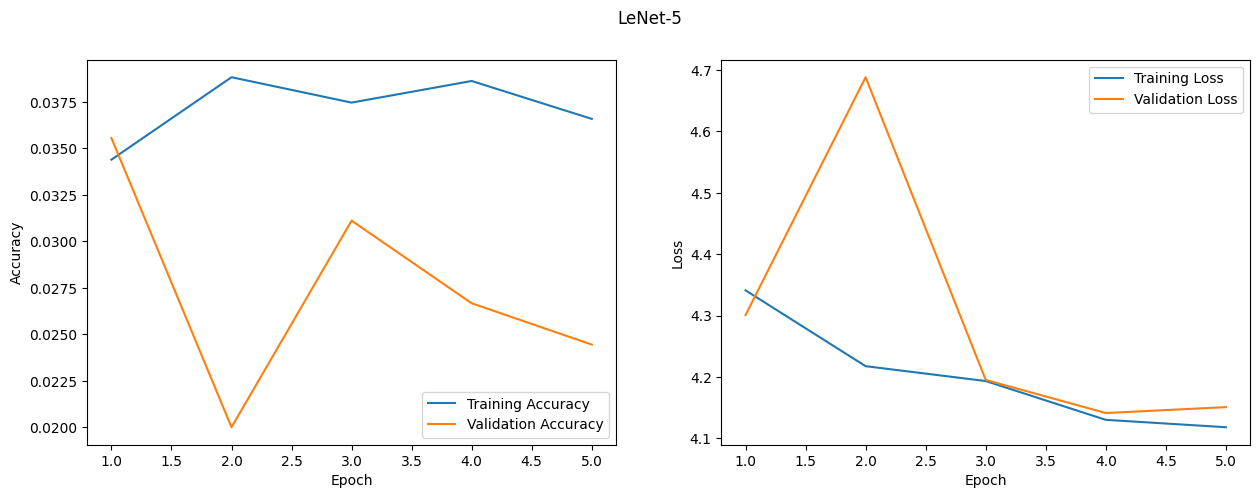

In [41]:
# Plot the accuracy and loss in the same figure
fig,ax = plt.subplots(1,2,figsize=(15, 5))
fig.suptitle('LeNet-5')
ax[0].plot(range(1,num_epochs+1),train_acc_list, label='Training Accuracy')
ax[0].plot(range(1,num_epochs+1),val_acc_list, label='Validation Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[1].plot(range(1,num_epochs+1),train_loss_list, label='Training Loss')
ax[1].plot(range(1,num_epochs+1),val_loss_list, label='Validation Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
plt.show()

In [42]:
train_loss, train_acc = 0, 0
val_loss, val_acc = 0, 0
test_loss, test_acc = 0, 0
### training
for i, (images, labels) in enumerate(train_loader):  
        # Forward pass
        loss, prediction = net.forward(images.numpy(),
                                        labels.numpy(),
                                        is_train=False)
        
        train_loss += loss
        train_acc += top_1_acc(labels.numpy(), prediction)
Train_acc = train_acc/len(train_loader)

### validation
for i, (images, labels) in enumerate(val_loader):
        # Forward pass
        loss, prediction = net.forward(images.numpy(),
                                        labels.numpy(),
                                        is_train=False)
        
        val_loss += loss
        val_acc += top_1_acc(labels.numpy(), prediction)
Val_acc = val_acc/len(val_loader)

### test
for i, (images, labels) in enumerate(test_loader):
        # Forward pass
        loss, prediction = net.forward(images.numpy(),
                                        labels.numpy(),
                                        is_train=False)
        
        test_loss += loss
        test_acc += top_1_acc(labels.numpy(), prediction)
Test_acc = test_acc/len(test_loader)


print('LeNet-5')
print('Train accuracy: {:.3f}; Val accuracy: {:.3f}; Test accuracy: {:.3f}'.format(
        Train_acc, Val_acc, Test_acc))

LeNet-5
Train accuracy: 0.038; Val accuracy: 0.024; Test accuracy: 0.044


## Improved LeNet5

* Activation function: x = Sigmoid(x) ==> x = x*sigmoid(x)
* Kernel size: 5x5 ==> 3x3
* Increase one convolution layer to LeNet5 (any position).

In [74]:
import importlib
importlib.reload(LeNet5_mini)

<module 'net.LeNet5_mini' from './numpy_realizes_CNN/net/LeNet5_mini.py'>

In [75]:
del net
net = LeNet5_mini.LeNet5_mini_Improved()

In [76]:
iterations_num = 0 # 记录训练的迭代次数

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
train_step = len(train_loader)
val_step = len(val_loader)
split_num = 2
for epoch in range(num_epochs):
    train_loss = 0
    val_loss = 0
    train_acc = 0
    val_acc = 0

    batch_loss = 0
    batch_acc = 0
    epoch_loss = 0
    epoch_acc = 0

    ### training
    for i, (images, labels) in enumerate(train_loader):  
        # Forward pass
        loss, prediction = net.forward(images.numpy(),
                                    labels.numpy(),
                                    is_train=True)
        
        train_loss += loss
        train_acc += top_1_acc(labels.numpy(), prediction)
        # for j in range(prediction.shape[0]):
        #     if np.argmax(prediction[j]) == labels[j]:
        #         train_acc += 1

        net.backward(learning_rate)

    train_loss_list.append(train_loss/train_step)
    train_acc_list.append(train_acc/train_step)

    ### validation
    for i, (images, labels) in enumerate(val_loader):  
        # Forward pass
        loss, prediction = net.forward(images.numpy(),
                                    labels.numpy(),
                                    is_train=False)
        
        val_loss += loss
        val_acc += top_1_acc(labels.numpy(), prediction)
        # for j in range(prediction.shape[0]):
        #     if np.argmax(prediction[j]) == labels[j]:
        #         val_acc += 1

    val_loss_list.append(val_loss/val_step)
    val_acc_list.append(val_acc/val_step)

    if (epoch+1)%(epoch+1) == 0:
        print("Epoch: {}: Train Loss: {:.3f}, Train accuracy: {:.3f}; Val Loss: {:.3f}, Val accuracy: {:.3f}".format(
            epoch+1, train_loss_list[-1], train_acc_list[-1], val_loss_list[-1], val_acc_list[-1]))

Epoch: 1: Train Loss: 4.902, Train accuracy: 0.024; Val Loss: 4.687, Val accuracy: 0.024
Epoch: 2: Train Loss: 4.491, Train accuracy: 0.030; Val Loss: 4.506, Val accuracy: 0.031
Epoch: 3: Train Loss: 4.342, Train accuracy: 0.035; Val Loss: 4.379, Val accuracy: 0.036
Epoch: 4: Train Loss: 4.234, Train accuracy: 0.039; Val Loss: 4.276, Val accuracy: 0.036
Epoch: 5: Train Loss: 4.150, Train accuracy: 0.043; Val Loss: 4.203, Val accuracy: 0.038


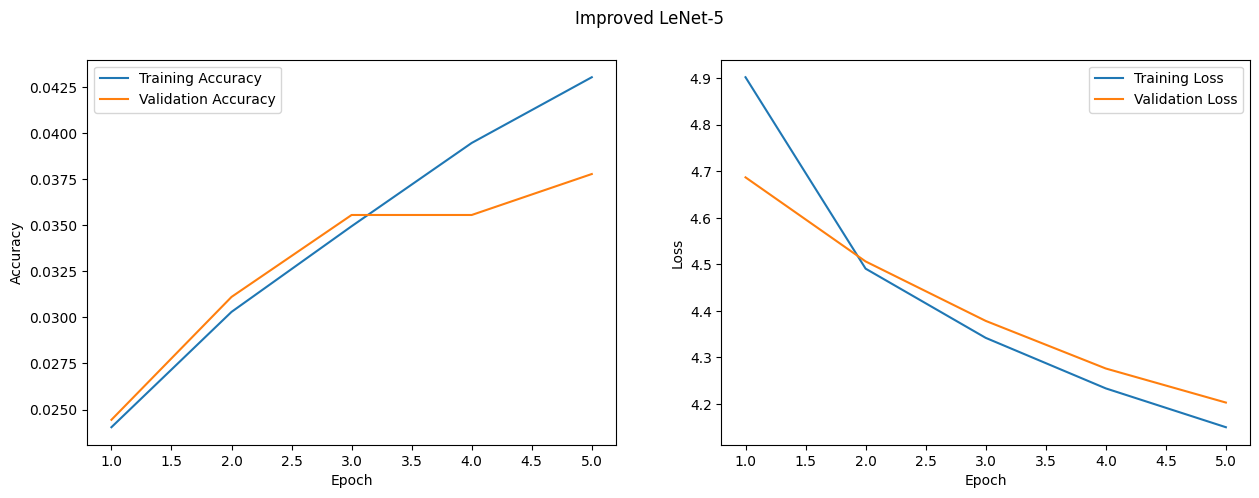

In [77]:
# Plot the accuracy and loss in the same figure
fig,ax = plt.subplots(1,2,figsize=(15, 5))
fig.suptitle('Improved LeNet-5')
ax[0].plot(range(1,num_epochs+1),train_acc_list, label='Training Accuracy')
ax[0].plot(range(1,num_epochs+1),val_acc_list, label='Validation Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[1].plot(range(1,num_epochs+1),train_loss_list, label='Training Loss')
ax[1].plot(range(1,num_epochs+1),val_loss_list, label='Validation Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
plt.show()

In [78]:
train_loss, train_acc = 0, 0
val_loss, val_acc = 0, 0
test_loss, test_acc = 0, 0
### training
for i, (images, labels) in enumerate(train_loader):  
        # Forward pass
        loss, prediction = net.forward(images.numpy(),
                                        labels.numpy(),
                                        is_train=False)
        
        train_loss += loss
        train_acc += top_1_acc(labels.numpy(), prediction)
Train_acc = train_acc/len(train_loader)

### validation
for i, (images, labels) in enumerate(val_loader):
        # Forward pass
        loss, prediction = net.forward(images.numpy(),
                                        labels.numpy(),
                                        is_train=False)
        
        val_loss += loss
        val_acc += top_1_acc(labels.numpy(), prediction)
Val_acc = val_acc/len(val_loader)

### test
for i, (images, labels) in enumerate(test_loader):
        # Forward pass
        loss, prediction = net.forward(images.numpy(),
                                        labels.numpy(),
                                        is_train=False)
        
        test_loss += loss
        test_acc += top_1_acc(labels.numpy(), prediction)
Test_acc = test_acc/len(test_loader)


print('Improved LeNet-5')
print('Train accuracy: {:.3f}; Val accuracy: {:.3f}; Test accuracy: {:.3f}'.format(
        Train_acc, Val_acc, Test_acc))

Improved LeNet-5
Train accuracy: 0.045; Val accuracy: 0.038; Test accuracy: 0.073
